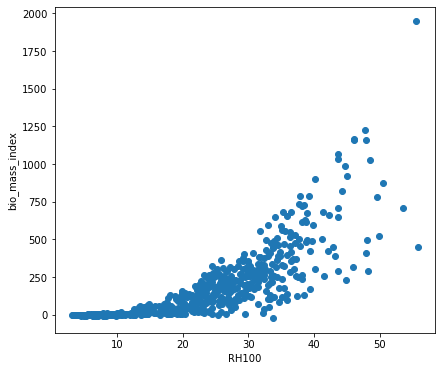

In [11]:
# import libs
import matplotlib.pyplot
import numpy as np
import pylab
import pandas as pd
import h5py
import geopandas as gpd
from shapely.geometry import *
from geopandas.geoseries import *
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
#Stats
from sklearn import linear_model
from scipy.stats import spearmanr
from scipy.stats import sem

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Importing data
##Trees
Trees = gpd.read_file(r'D:\Gabon_Lidar\DATA\shp\Mondah_Field_Data_Trees_in_study_site_lat_lon_a.shp')

#Import Geo
##Buffers

LVIS_5m = gpd.read_file(r'D:\Gabon_Lidar\DATA\shp\LVIS2_Gabon2016_5m.shp')

LVIS_10m = gpd.read_file(r'D:\Gabon_Lidar\DATA\shp\LVIS2_Gabon2016_10m.shp')

LVIS_125m = gpd.read_file(r'D:\Gabon_Lidar\DATA\shp\LVIS2_Gabon2016_125m.shp')
#Trees

##Covert to wgs 1984
Trees = Trees.to_crs(epsg=4326)

Trees['tree_count'] = 1
Trees['ht_sq'] = Trees['h_t_mod']**2


#Adjesting Var
#Here is where the bean size and the data collection area can be changed.



#LVIS_shotdata has the shot data
LVIS_shotdata = LVIS_5m
#Add L1 DATA
L2 =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\L2_w_agbd2.csv')

LVIS_shotdata  = LVIS_shotdata.merge(L2, on='SHOTNUMBER', how='left')





#Filter out those with missing biomass data
LVIS_shotdata = LVIS_shotdata.dropna()


import matplotlib.pyplot as plt
#subplots0625['subplot'] = subplots0625['subplot'].astype(str)

RH100 = LVIS_shotdata['RH100']

bio_mass_index= LVIS_shotdata['bio_mass_index']

#Chart 1
fig = plt.figure(figsize=(15, 6))
figplot = fig.add_subplot(121)
figplot.scatter(RH100,bio_mass_index)
plt.ylabel('bio_mass_index')
plt.xlabel('RH100')



#ADD geodata
LVIS_shotdata= LVIS_shotdata.to_crs(epsg=4326)


# The next steps create a var called shotsize based on a buffer of the beam.
#LVIS_shotsize has the geodata
LVIS_shotsize = LVIS_125m
#Changing CRS
LVIS_shotsize = LVIS_shotsize.to_crs(epsg=4326)
#Select only shotnumber on geo
area = ['SHOTNUMBER','geometry']
#Give it those atrubutes
LVIS_shotsize = LVIS_shotsize[area]
#Rename shotnumber to GeoArea
LVIS_shotsize['GeoArea'] = LVIS_shotsize['SHOTNUMBER']

## Bring in the Plots

#subplots0625
subplots0625 = gpd.read_file(r'D:\Gabon_Lidar\DATA\shp\Mondah_Field_Data_Plot-0_625ha.shp')
subplots0625= subplots0625.to_crs(epsg=4326)
subplots0625['subplot'] = subplots0625['subplot'].astype(str)
subplots0625['GeoArea'] = subplots0625['plot'] + subplots0625['subplot']

#subplots025
subplots025 = gpd.read_file(r'D:\Gabon_Lidar\DATA\shp\Mondah_Field_Data_Plot-0_25ha.shp')
subplots025= subplots025.to_crs(epsg=4326)
subplots025['subplot'] = subplots025['subplot'].astype(str)
subplots025['GeoArea'] = subplots025['plot'] + subplots025['subplot']

#Whole Plot*****Fix******
#subplots1 = gpd.read_file(r'D:\Gabon_Lidar\DATA\shp\Mondah_Field_Data_Plot1ha_good.shp')
#subplots1 = subplots1.to_crs(epsg=4326)
#subplots1 = subplots1['GeoArea'] = subplots1['plot']

#Selecting GeoAREA
plot = LVIS_shotsize
geo = plot

#Processing Tree DATA
Trees = Trees.to_crs(epsg=4326)

#Joining Tree with the GeoDATA
trees_in_geo = gpd.overlay(Trees, geo, how = 'intersection')

#Joining with Shotdata
trees_in_geo_shot = gpd.overlay(trees_in_geo,LVIS_shotdata, how = 'intersection')

##Finding the RSE Relative Standard Error
#Find the Canopy Profile **Quartit mean***
trees_in_geo_shot['Canopy_Profile1'] = (trees_in_geo_shot['ht_sq'] / trees_in_geo_shot['tree_count'] )**.5
#Create a table with Just the Canopy Profile
RSE = ['GeoArea', 'Canopy_Profile1']
#Filter for a table with just those fields
trees_in_geo_shot_RSE = trees_in_geo_shot[RSE]
#Find the Standard Error by GeoArea
trees_in_geo_shot_RSE_d = trees_in_geo_shot_RSE.groupby(['GeoArea']).sem()
#Create a new table
trees_in_geo_shot_RSE_d.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_shot_RSE_d.csv')
trees_in_geo_shot_RSE_d =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_shot_RSE_d.csv')
#Change the Columns Names
trees_in_geo_shot_RSE.columns = ['GeoArea', 'RSE']
#DAata Cleaning
trees_in_geo_shot_RSE= trees_in_geo_shot_RSE.groupby(by='GeoArea').max()
#Cover All NA to Zero
trees_in_geo_shot_RSE['RSE'] = trees_in_geo_shot_RSE['RSE'].fillna(0)
#Create a new table
trees_in_geo_shot_RSE.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_shot_RSE.csv')
trees_in_geo_shot_RSE =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_shot_RSE.csv')

#correlation coefficient - Running spearman
#Creating Filter
spearmanr = ['GeoArea', 'Canopy_Profile1', 'm_agb']
#Filter for Just those threre fields
trees_in_geo_shot_corr = trees_in_geo_shot[spearmanr]
trees_in_geo_shot_corr_d = trees_in_geo_shot_corr.groupby('GeoArea')[['Canopy_Profile1', 'm_agb']].corr().iloc[0::2][['m_agb']]
#Create a new table
trees_in_geo_shot_corr_d.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_shot_corr_d.csv')
trees_in_geo_shot_corr_d =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_shot_corr_d.csv')
#Drop the columns
trees_in_geo_shot_corr_d= trees_in_geo_shot_corr_d.drop(columns='Unnamed: 1')
#Rename the Columns
trees_in_geo_shot_corr_d.columns = ['GeoArea', 'CC']
trees_in_geo_shot_corr_d = trees_in_geo_shot_corr_d.groupby(by='GeoArea').max()
#Change the NA to 0
trees_in_geo_shot_corr_d['CC'] = trees_in_geo_shot_corr_d['CC'].fillna(0)
#Create a new table
trees_in_geo_shot_corr_d.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_shot_corr_d.csv')
trees_in_geo_shot_corr_d =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_shot_corr_d.csv')

#SUM
sum = ['GeoArea', 'm_agb','h_t_mod','tree_count','ht_sq','bio_mass_index','Canopy_Profile1','agbd']
trees_in_geo_sum = trees_in_geo_shot[sum]
trees_in_geo_sum = trees_in_geo_sum.groupby(by='GeoArea').sum()
trees_in_geo_sum.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_sum.csv')
trees_in_geo_sum =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_sum.csv')
trees_in_geo_sum.columns = ['GeoArea', 'm_agb_sum', 'h_t_mod_sum', 'tree_count_sum', 'ht_sq_sum','bio_mass_index_sum','Canopy_Profile1','agbd_sum']

#MEAN
mean = ['GeoArea','h_t_mod','ht_sq','m_agb','RH10',
       'RH15', 'RH20', 'RH25', 'RH30', 'RH35', 'RH40', 'RH45', 'RH50', 'RH55',
       'RH60', 'RH65', 'RH70', 'RH75', 'RH80', 'RH85', 'RH90', 'RH95', 'RH96',
       'RH97', 'RH98', 'RH99', 'RH100','bio_mass_index']
trees_in_geo = trees_in_geo_shot[mean]
trees_in_geo_mean = trees_in_geo.groupby(by='GeoArea').mean()
trees_in_geo_mean.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_mean.csv')
trees_in_geo_mean =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_mean.csv')
trees_in_geo_mean.columns = ['GeoArea','h_t_mod_mean','ht_sq_mean','m_agb_mean','RH10avg',
       'RH15avg', 'RH20avg', 'RH25avg', 'RH30avg', 'RH35avg', 'RH40avg', 'RH45avg', 'RH50avg', 'RH55avg',
       'RH60avg', 'RH65avg', 'RH70avg', 'RH75avg', 'RH80avg', 'RH85avg', 'RH90avg', 'RH95avg', 'RH96avg',
       'RH97avg', 'RH98avg', 'RH99avg', 'RH100avg','bio_mass_index_mean']

#MAX
max = ['GeoArea','RH10',
       'RH15', 'RH20', 'RH25', 'RH30', 'RH35', 'RH40', 'RH45', 'RH50', 'RH55',
       'RH60', 'RH65', 'RH70', 'RH75', 'RH80', 'RH85', 'RH90', 'RH95', 'RH96',
       'RH97', 'RH98', 'RH99', 'RH100','h_t_mod']
trees_in_geo = trees_in_geo_shot[max]
trees_in_geo_max = trees_in_geo.groupby(by='GeoArea').max()
trees_in_geo_max.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_max.csv')
trees_in_geo_max =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo_max.csv')
trees_in_geo_max.columns = ['GeoArea','RH10mx',
       'RH15mx', 'RH20mx', 'RH25mx', 'RH30mx', 'RH35mx', 'RH40mx', 'RH45mx', 'RH50mx', 'RH55mx',
       'RH60mx', 'RH65mx', 'RH70mx', 'RH75mx', 'RH80mx', 'RH85mx', 'RH90mx', 'RH95mx', 'RH96mx',
       'RH97mx', 'RH98mx', 'RH99mx', 'RH100mx','h_t_modmax']

##Joining The Table Back Together
#Join Sum and MAX
trees_in_geo = trees_in_geo_max.set_index('GeoArea').join(trees_in_geo_sum.set_index('GeoArea'))
trees_in_geo.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')
trees_in_geo =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')
#Join MEAN
trees_in_geo =  trees_in_geo.set_index('GeoArea').join(trees_in_geo_mean.set_index('GeoArea'))
trees_in_geo.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')
trees_in_geo =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')
#Join CC
trees_in_geo =  trees_in_geo.set_index('GeoArea').join(trees_in_geo_shot_corr_d.set_index('GeoArea'))
trees_in_geo.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')
trees_in_geo =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')
#Join RSE
trees_in_geo =  trees_in_geo.set_index('GeoArea').join(trees_in_geo_shot_RSE .set_index('GeoArea'))
trees_in_geo.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')
trees_in_geo =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')







#quantitative_mean
trees_in_geo['quantitative_mean'] = (trees_in_geo['ht_sq_sum'] / trees_in_geo['tree_count_sum'] )**.5
trees_in_geo.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')
trees_in_geo =pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\trees_in_geo.csv')


In [12]:
####Biomass inex vs RH100

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     bio_mass_index_mean   R-squared (uncentered):                   0.761
Model:                             OLS   Adj. R-squared (uncentered):              0.760
Method:                  Least Squares   F-statistic:                              1946.
Date:                 Mon, 28 Dec 2020   Prob (F-statistic):                   3.27e-192
Time:                         21:59:46   Log-Likelihood:                         -3850.4
No. Observations:                  613   AIC:                                      7703.
Df Residuals:                      612   BIC:                                      7707.
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RH100avg       9.2789      0.210     44.109      0.000       8.866       9.692
==============================================================================
Omnibus:                      375.650   Durbin-Watson:                   0.383
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2991.869
Skew:                           2.716   Prob(JB):                         0.00
Kurtosis:                      12.361   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

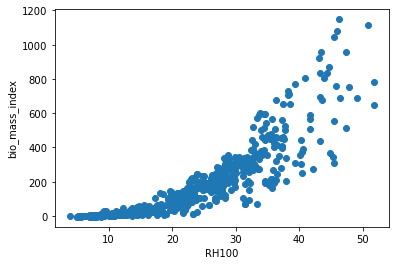

In [13]:
####Biomass inex vs RH100

bio_mass_index = trees_in_geo['bio_mass_index_mean']
RH100 = trees_in_geo['RH100avg']

#Chart 1
fig = plt.figure()
figplot = fig.add_subplot()
figplot.scatter(RH100,bio_mass_index)
plt.ylabel('bio_mass_index')
plt.xlabel('RH100')

#Stats 
model = sm.OLS(bio_mass_index,RH100).fit()
model.summary()

In [14]:
### AGB vs RH100

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             m_agb_mean   R-squared (uncentered):                   0.257
Model:                            OLS   Adj. R-squared (uncentered):              0.256
Method:                 Least Squares   F-statistic:                              211.9
Date:                Mon, 28 Dec 2020   Prob (F-statistic):                    1.93e-41
Time:                        21:59:46   Log-Likelihood:                         -4557.8
No. Observations:                 613   AIC:                                      9118.
Df Residuals:                     612   BIC:                                      9122.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RH100avg       9.7094      0.667     14.558      0.000       8.400      11.019
==============================================================================
Omnibus:                      876.575   Durbin-Watson:                   0.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           153936.156
Skew:                           7.811   Prob(JB):                         0.00
Kurtosis:                      79.045   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

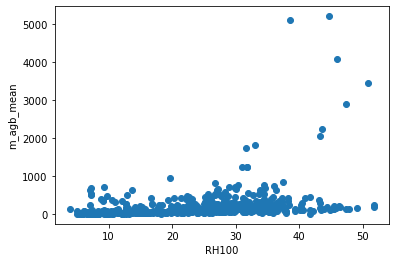

In [15]:
m_agb_mean= trees_in_geo['m_agb_mean']
RH100 = trees_in_geo['RH100avg']


#Chart 1
fig = plt.figure()
figplot = fig.add_subplot()
figplot.scatter(RH100,m_agb_mean)
plt.ylabel('m_agb_mean')
plt.xlabel('RH100')

#Stats 
model = sm.OLS(m_agb_mean,RH100).fit()
model.summary()


In [16]:
### agb vs biomass index mean 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     bio_mass_index_mean   R-squared (uncentered):                   0.367
Model:                             OLS   Adj. R-squared (uncentered):              0.366
Method:                  Least Squares   F-statistic:                              354.6
Date:                 Mon, 28 Dec 2020   Prob (F-statistic):                    9.78e-63
Time:                         21:59:46   Log-Likelihood:                         -4148.7
No. Observations:                  613   AIC:                                      8299.
Df Residuals:                      612   BIC:                                      8304.
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
m_agb_sum      0.0206      0.001     18.830      0.000       0.018       0.023
==============================================================================
Omnibus:                      177.932   Durbin-Watson:                   0.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2093.751
Skew:                           0.929   Prob(JB):                         0.00
Kurtosis:                      11.861   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

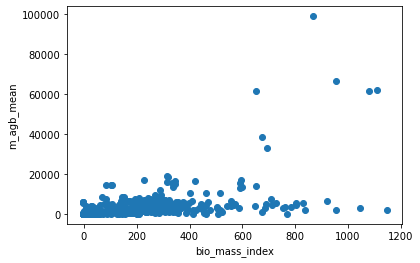

In [17]:
m_agb_mean= trees_in_geo['m_agb_sum']
bio_mass_index = trees_in_geo['bio_mass_index_mean']
#Chart 1
fig = plt.figure()
figplot = fig.add_subplot()
figplot.scatter(bio_mass_index,m_agb_mean)
plt.xlabel('bio_mass_index')
plt.ylabel('m_agb_mean')


#Stats 
model = sm.OLS(bio_mass_index,m_agb_mean).fit()
model.summary()


In [18]:
####AGBD vs RH25 index

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               agbd_sum   R-squared (uncentered):                   0.462
Model:                            OLS   Adj. R-squared (uncentered):              0.461
Method:                 Least Squares   F-statistic:                              525.4
Date:                Mon, 28 Dec 2020   Prob (F-statistic):                    2.03e-84
Time:                        21:59:47   Log-Likelihood:                         -4364.4
No. Observations:                 613   AIC:                                      8731.
Df Residuals:                     612   BIC:                                      8735.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RH25avg       37.8150      1.650     22.922      0.000      34.575      41.055
==============================================================================
Omnibus:                      421.960   Durbin-Watson:                   0.680
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6158.344
Skew:                           2.892   Prob(JB):                         0.00
Kurtosis:                      17.410   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

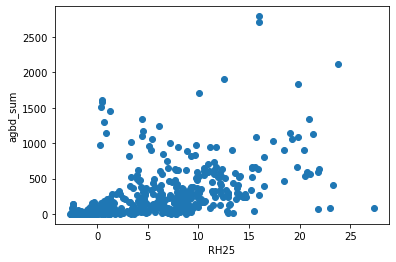

In [19]:
agbd_sum = trees_in_geo['agbd_sum']
RH25 = trees_in_geo['RH25avg']

#Chart 1
fig = plt.figure()
figplot = fig.add_subplot()
figplot.scatter(RH25,agbd_sum)
plt.ylabel('agbd_sum')
plt.xlabel('RH25')

#Stats 
model = sm.OLS(agbd_sum,RH25).fit()
model.summary()


In [20]:
####AGBD vs RH50 index

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               agbd_sum   R-squared (uncentered):                   0.546
Model:                            OLS   Adj. R-squared (uncentered):              0.545
Method:                 Least Squares   F-statistic:                              735.0
Date:                Mon, 28 Dec 2020   Prob (F-statistic):                   6.33e-107
Time:                        21:59:56   Log-Likelihood:                         -4312.6
No. Observations:                 613   AIC:                                      8627.
Df Residuals:                     612   BIC:                                      8632.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RH50avg       26.1052      0.963     27.110      0.000      24.214      27.996
==============================================================================
Omnibus:                      422.887   Durbin-Watson:                   0.689
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5899.645
Skew:                           2.922   Prob(JB):                         0.00
Kurtosis:                      17.030   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

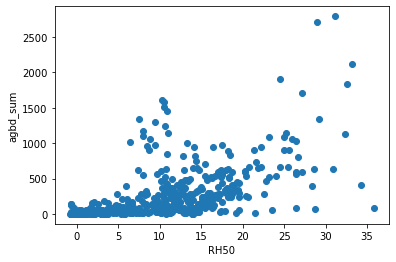

In [22]:
#AGBD RH50 index

agbd_sum = trees_in_geo['agbd_sum']
RH50 = trees_in_geo['RH50avg']

#Chart 1
fig = plt.figure()
figplot = fig.add_subplot()
figplot.scatter(RH50,agbd_sum)
plt.ylabel('agbd_sum')
plt.xlabel('RH50')

#Stats 
model = sm.OLS(agbd_sum,RH50).fit()
model.summary()

In [23]:
####AGBD vs RH75 index

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               agbd_sum   R-squared (uncentered):                   0.544
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                              730.3
Date:                Mon, 28 Dec 2020   Prob (F-statistic):                   1.83e-106
Time:                        21:59:58   Log-Likelihood:                         -4313.7
No. Observations:                 613   AIC:                                      8629.
Df Residuals:                     612   BIC:                                      8634.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RH75avg       19.0289      0.704     27.024      0.000      17.646      20.412
==============================================================================
Omnibus:                      449.279   Durbin-Watson:                   0.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7099.524
Skew:                           3.135   Prob(JB):                         0.00
Kurtosis:                      18.448   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

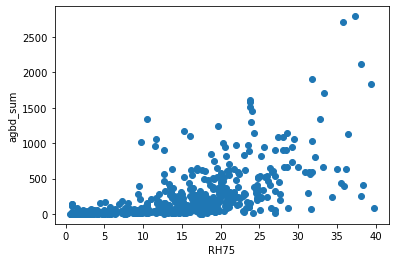

In [24]:
#AGBD RH75 index

agbd_sum = trees_in_geo['agbd_sum']
RH75 = trees_in_geo['RH75avg']

#Chart 1
fig = plt.figure()
figplot = fig.add_subplot()
figplot.scatter(RH75,agbd_sum)
plt.ylabel('agbd_sum')
plt.xlabel('RH75')


#Stats 
model = sm.OLS(agbd_sum,RH75).fit()
model.summary()

In [25]:
####AGBD vs RH75 index

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               agbd_sum   R-squared (uncentered):                   0.463
Model:                            OLS   Adj. R-squared (uncentered):              0.462
Method:                 Least Squares   F-statistic:                              526.9
Date:                Mon, 28 Dec 2020   Prob (F-statistic):                    1.38e-84
Time:                        21:59:59   Log-Likelihood:                         -4364.0
No. Observations:                 613   AIC:                                      8730.
Df Residuals:                     612   BIC:                                      8734.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RH100avg      11.1609      0.486     22.954      0.000      10.206      12.116
==============================================================================
Omnibus:                      476.700   Durbin-Watson:                   0.641
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7882.429
Skew:                           3.406   Prob(JB):                         0.00
Kurtosis:                      19.192   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

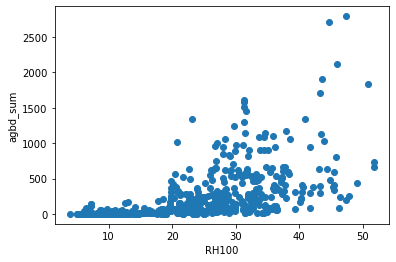

In [26]:
agbd_sum = trees_in_geo['agbd_sum']
RH100 = trees_in_geo['RH100avg']

#Chart 1
fig = plt.figure()
figplot = fig.add_subplot()
figplot.scatter(RH100,agbd_sum)
plt.ylabel('agbd_sum')
plt.xlabel('RH100')

#Stats 
model = sm.OLS(agbd_sum,RH100).fit()
model.summary()